# *Sentiment Analysis and Product Recommendation on Amazon’s Electronics Dataset Reviews*

*While taking the decision consumers want to find useful reviews as quickly as possible using rating system. Therefore, models should be capable to predict the user rating from the reviews are important. Getting an overall sense of a textual review could in turn improve consumer experience and satisfaction. Also, it can help businesses to increase sales, and improve the product by understanding customer’s needs.<br> Here amazon review dataset was taken. The reviews and ratings given by the user to different products as well as reviews about the user's experience are also included*

## *Problem statement*
*The aim is to deploy a model to predict the ratings, usefulness of the review and recommnend most similar items to the user based on collaborative filtering* 

## Dataset information: 
### Review
"reviewerID": "A2SUAM1J3GNN3B",  

"asin": "0000013714",  

"reviewerName": "J. McDonald",  

"helpful": [2, 3],  

"reviewText": "I bought this for my husband who plays the piano.  He is having a wonderful time playing these old hymns.  The music  is at times hard to read because we think the book was published for singing from more than playing from.  Great purchase though!",  

"overall": 5.0,  

"summary": "Heavenly Highway Hymns",  

"unixReviewTime": 1252800000,  

"reviewTime": "09 13, 2009"  

***

### Metadata: 
"asin" - "ID of the product, e.g. 0000031852"

"title" - "name of the product"

"price" - "price in US dollars (at time of crawl)"

"imUrl" - "url of the product image"

"related" - "related products (also bought, also viewed, bought together, buy after viewing)"

"salesRank" - "sales rank information"

"brand" - "brand name"

"categories" - "list of categories the product belongs to"

## Importing the data

In [1]:
import pandas as pd
import gzip
import dask.bag as db
import datetime
import seaborn as sns 
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# Text pre processing 
import re
import nltk
from nltk.corpus import stopwords
from nltk import word_tokenize, sent_tokenize
from nltk.stem.lancaster import LancasterStemmer
from nltk.stem import WordNetLemmatizer


def parse(path):
  g = gzip.open(path, 'rb')
  for l in g:
    yield eval(l)
    
# Function to convert json to Pandas DF: 
def getDF(path):
  i = 0
  df = {}
  for d in parse(path):
    df[i] = d
    i += 1
  return pd.DataFrame.from_dict(df, orient='index')

In [2]:
true = True
false = False

In [3]:
# review = getDF('reviews_Electronics_5.json.gz')
review = getDF('reviews_Electronics_5.json.gz')

review.head() 

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,AO94DHGC771SJ,0528881469,amazdnu,"[0, 0]",We got this GPS for my husband who is an (OTR)...,5.0,Gotta have GPS!,1370131200,"06 2, 2013"
1,AMO214LNFCEI4,0528881469,Amazon Customer,"[12, 15]","I'm a professional OTR truck driver, and I bou...",1.0,Very Disappointed,1290643200,"11 25, 2010"
2,A3N7T0DY83Y4IG,0528881469,C. A. Freeman,"[43, 45]","Well, what can I say. I've had this unit in m...",3.0,1st impression,1283990400,"09 9, 2010"
3,A1H8PY3QHMQQA0,0528881469,"Dave M. Shaw ""mack dave""","[9, 10]","Not going to write a long review, even thought...",2.0,"Great grafics, POOR GPS",1290556800,"11 24, 2010"
4,A24EV6RXELQZ63,0528881469,Wayne Smith,"[0, 0]",I've had mine for a year and here's what we go...,1.0,"Major issues, only excuses for support",1317254400,"09 29, 2011"


In [4]:
meta = getDF('meta_Electronics.json.gz')
meta.head() 

,asin,imUrl,description,categories,title,price,salesRank,related,brand
0,0132793040,http://ecx.images-amazon.com/images/I/31JIPhp%...,The Kelby Training DVD Mastering Blend Modes i...,"[[Electronics, Computers & Accessories, Cables...",Kelby Training DVD: Mastering Blend Modes in A...,NaN,NaN,NaN,NaN
1,0321732944,http://ecx.images-amazon.com/images/I/31uogm6Y...,NaN,"[[Electronics, Computers & Accessories, Cables...",Kelby Training DVD: Adobe Photoshop CS5 Crash ...,NaN,NaN,NaN,NaN
2,0439886341,http://ecx.images-amazon.com/images/I/51k0qa8f...,Digital Organizer and Messenger,"[[Electronics, Computers & Accessories, PDAs, ...",Digital Organizer and Messenger,8.15,{'Electronics': 144944},"{'also_viewed': ['0545016266', 'B009ECM8QY', '...",NaN
3,0511189877,http://ecx.images-amazon.com/images/I/41HaAhbv...,The CLIKR-5 UR5U-8780L remote control is desig...,"[[Electronics, Accessories & Supplies, Audio &...",CLIKR-5 Time Warner Cable Remote Control UR5U-...,23.36,NaN,"{'also_viewed': ['B001KC08A4', 'B00KUL8O0W', '...",NaN
4,0528881469,http://ecx.images-amazon.com/images/I/51FnRkJq...,"Like its award-winning predecessor, the Intell...","[[Electronics, GPS & Navigation, Vehicle GPS, ...",Rand McNally 528881469 7-inch Intelliroute TND...,299.99,NaN,"{'also_viewed': ['B006ZOI9OY', 'B00C7FKT2A', '...",NaN


### Shape of the datasets: 

In [5]:
review.shape, meta.shape

((1689188, 9), (498196, 9))

##### Function for column names (neat)

In [6]:
def col(df):
    i = 1
    for col in df.columns: 
        print(str(i) + ') ' + col)
        i += 1

In [7]:
col(review)

1) reviewerID
2) asin
3) reviewerName
4) helpful
5) reviewText
6) overall
7) summary
8) unixReviewTime
9) reviewTime


In [8]:
col(meta)

1) asin
2) imUrl
3) description
4) categories
5) title
6) price
7) salesRank
8) related
9) brand


### Merge the two datasets based on the column 'asin'

In [9]:
df = pd.merge(review, meta, on = 'asin', how = 'left')

In [10]:
df.head()

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime,imUrl,description,categories,title,price,salesRank,related,brand
0,AO94DHGC771SJ,0528881469,amazdnu,"[0, 0]",We got this GPS for my husband who is an (OTR)...,5.0,Gotta have GPS!,1370131200,"06 2, 2013",http://ecx.images-amazon.com/images/I/51FnRkJq...,"Like its award-winning predecessor, the Intell...","[[Electronics, GPS & Navigation, Vehicle GPS, ...",Rand McNally 528881469 7-inch Intelliroute TND...,299.99,NaN,"{'also_viewed': ['B006ZOI9OY', 'B00C7FKT2A', '...",NaN
1,AMO214LNFCEI4,0528881469,Amazon Customer,"[12, 15]","I'm a professional OTR truck driver, and I bou...",1.0,Very Disappointed,1290643200,"11 25, 2010",http://ecx.images-amazon.com/images/I/51FnRkJq...,"Like its award-winning predecessor, the Intell...","[[Electronics, GPS & Navigation, Vehicle GPS, ...",Rand McNally 528881469 7-inch Intelliroute TND...,299.99,NaN,"{'also_viewed': ['B006ZOI9OY', 'B00C7FKT2A', '...",NaN
2,A3N7T0DY83Y4IG,0528881469,C. A. Freeman,"[43, 45]","Well, what can I say. I've had this unit in m...",3.0,1st impression,1283990400,"09 9, 2010",http://ecx.images-amazon.com/images/I/51FnRkJq...,"Like its award-winning predecessor, the Intell...","[[Electronics, GPS & Navigation, Vehicle GPS, ...",Rand McNally 528881469 7-inch Intelliroute TND...,299.99,NaN,"{'also_viewed': ['B006ZOI9OY', 'B00C7FKT2A', '...",NaN
3,A1H8PY3QHMQQA0,0528881469,"Dave M. Shaw ""mack dave""","[9, 10]","Not going to write a long review, even thought...",2.0,"Great grafics, POOR GPS",1290556800,"11 24, 2010",http://ecx.images-amazon.com/images/I/51FnRkJq...,"Like its award-winning predecessor, the Intell...","[[Electronics, GPS & Navigation, Vehicle GPS, ...",Rand McNally 528881469 7-inch Intelliroute TND...,299.99,NaN,"{'also_viewed': ['B006ZOI9OY', 'B00C7FKT2A', '...",NaN
4,A24EV6RXELQZ63,0528881469,Wayne Smith,"[0, 0]",I've had mine for a year and here's what we go...,1.0,"Major issues, only excuses for support",1317254400,"09 29, 2011",http://ecx.images-amazon.com/images/I/51FnRkJq...,"Like its award-winning predecessor, the Intell...","[[Electronics, GPS & Navigation, Vehicle GPS, ...",Rand McNally 528881469 7-inch Intelliroute TND...,299.99,NaN,"{'also_viewed': ['B006ZOI9OY', 'B00C7FKT2A', '...",NaN


In [11]:
df.isnull().sum() 

reviewerID             0
asin                   0
reviewerName       24730
helpful                0
reviewText             0
overall                0
summary                0
unixReviewTime         0
reviewTime             0
imUrl               1213
description        33677
categories             0
title              45502
price              49306
salesRank         879118
related            27046
brand             734937
dtype: int64

In [12]:
temp = df.copy() 

In [13]:
temp = df.dropna(subset = ['title'])

In [14]:
temp.head() 

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime,imUrl,description,categories,title,price,salesRank,related,brand
0,AO94DHGC771SJ,0528881469,amazdnu,"[0, 0]",We got this GPS for my husband who is an (OTR)...,5.0,Gotta have GPS!,1370131200,"06 2, 2013",http://ecx.images-amazon.com/images/I/51FnRkJq...,"Like its award-winning predecessor, the Intell...","[[Electronics, GPS & Navigation, Vehicle GPS, ...",Rand McNally 528881469 7-inch Intelliroute TND...,299.99,NaN,"{'also_viewed': ['B006ZOI9OY', 'B00C7FKT2A', '...",NaN
1,AMO214LNFCEI4,0528881469,Amazon Customer,"[12, 15]","I'm a professional OTR truck driver, and I bou...",1.0,Very Disappointed,1290643200,"11 25, 2010",http://ecx.images-amazon.com/images/I/51FnRkJq...,"Like its award-winning predecessor, the Intell...","[[Electronics, GPS & Navigation, Vehicle GPS, ...",Rand McNally 528881469 7-inch Intelliroute TND...,299.99,NaN,"{'also_viewed': ['B006ZOI9OY', 'B00C7FKT2A', '...",NaN
2,A3N7T0DY83Y4IG,0528881469,C. A. Freeman,"[43, 45]","Well, what can I say. I've had this unit in m...",3.0,1st impression,1283990400,"09 9, 2010",http://ecx.images-amazon.com/images/I/51FnRkJq...,"Like its award-winning predecessor, the Intell...","[[Electronics, GPS & Navigation, Vehicle GPS, ...",Rand McNally 528881469 7-inch Intelliroute TND...,299.99,NaN,"{'also_viewed': ['B006ZOI9OY', 'B00C7FKT2A', '...",NaN
3,A1H8PY3QHMQQA0,0528881469,"Dave M. Shaw ""mack dave""","[9, 10]","Not going to write a long review, even thought...",2.0,"Great grafics, POOR GPS",1290556800,"11 24, 2010",http://ecx.images-amazon.com/images/I/51FnRkJq...,"Like its award-winning predecessor, the Intell...","[[Electronics, GPS & Navigation, Vehicle GPS, ...",Rand McNally 528881469 7-inch Intelliroute TND...,299.99,NaN,"{'also_viewed': ['B006ZOI9OY', 'B00C7FKT2A', '...",NaN
4,A24EV6RXELQZ63,0528881469,Wayne Smith,"[0, 0]",I've had mine for a year and here's what we go...,1.0,"Major issues, only excuses for support",1317254400,"09 29, 2011",http://ecx.images-amazon.com/images/I/51FnRkJq...,"Like its award-winning predecessor, the Intell...","[[Electronics, GPS & Navigation, Vehicle GPS, ...",Rand McNally 528881469 7-inch Intelliroute TND...,299.99,NaN,"{'also_viewed': ['B006ZOI9OY', 'B00C7FKT2A', '...",NaN


### We are interested in finding the reviews and rating for headphones. 

In [15]:
condition = temp['title'].str.contains('headphones|Headphones|Headphone|headphone')

In [16]:
temp1 = temp[condition]

In [17]:
temp1.head() 

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime,imUrl,description,categories,title,price,salesRank,related,brand
1260,A3UFCX1AE4TKZE,B00000DMA3,Ben,"[11, 11]",I've been using these for over a year now. Ba...,4.0,"Good sound, Good Noise Cancelling, Good for ai...",1104796800,"01 4, 2005",http://ecx.images-amazon.com/images/I/5156BXCV...,"Retreat to a world of music, sleep on airplane...","[[Electronics, Accessories & Supplies, Audio &...",Sony MDR-NC20 Noise Canceling Headphones with ...,109.94,NaN,"{'also_viewed': ['B000U07C1U', 'B001EYU3L2', '...",NaN
1261,A33FS5H3CPDR6D,B00000DMA3,"Miguel Ali ""Film Director & Political Pundit""","[12, 13]",I will admit that I recently gave up my Sony H...,5.0,Best Noise Cancelling Headphones,1106524800,"01 24, 2005",http://ecx.images-amazon.com/images/I/5156BXCV...,"Retreat to a world of music, sleep on airplane...","[[Electronics, Accessories & Supplies, Audio &...",Sony MDR-NC20 Noise Canceling Headphones with ...,109.94,NaN,"{'also_viewed': ['B000U07C1U', 'B001EYU3L2', '...",NaN
1262,A1Q5M90ZZEEAL1,B00000DMA3,Niall O'Driscoll,"[8, 9]",I bought these thinking they were the ticket t...,3.0,Not what I'd hoped for.,1096934400,"10 5, 2004",http://ecx.images-amazon.com/images/I/5156BXCV...,"Retreat to a world of music, sleep on airplane...","[[Electronics, Accessories & Supplies, Audio &...",Sony MDR-NC20 Noise Canceling Headphones with ...,109.94,NaN,"{'also_viewed': ['B000U07C1U', 'B001EYU3L2', '...",NaN
1263,A1N03V52IRZ5PR,B00000DMA3,"N. J. Simicich ""Gadget Geek""","[0, 0]",I've owned these for years. I used to fly two ...,5.0,"The ""Get Smart"" Cone of Silence has finally be...",1093305600,"08 24, 2004",http://ecx.images-amazon.com/images/I/5156BXCV...,"Retreat to a world of music, sleep on airplane...","[[Electronics, Accessories & Supplies, Audio &...",Sony MDR-NC20 Noise Canceling Headphones with ...,109.94,NaN,"{'also_viewed': ['B000U07C1U', 'B001EYU3L2', '...",NaN
1264,A1W5G9ITZQ64TN,B00000DMA3,Stephen McLin,"[10, 12]",I have used the headphones for 2 years -- they...,5.0,Great product,1117929600,"06 5, 2005",http://ecx.images-amazon.com/images/I/5156BXCV...,"Retreat to a world of music, sleep on airplane...","[[Electronics, Accessories & Supplies, Audio &...",Sony MDR-NC20 Noise Canceling Headphones with ...,109.94,NaN,"{'also_viewed': ['B000U07C1U', 'B001EYU3L2', '...",NaN


In [18]:
hp = temp1.copy() 

In [19]:
# Checking for missing values: 

hp.isnull().sum() 

reviewerID            0
asin                  0
reviewerName        783
helpful               0
reviewText            0
overall               0
summary               0
unixReviewTime        0
reviewTime            0
imUrl                 0
description        1431
categories            0
title                 0
price               750
salesRank         42676
related            1009
brand             22699
dtype: int64

In [20]:
hp[hp['brand'].isnull()]

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime,imUrl,description,categories,title,price,salesRank,related,brand
1260,A3UFCX1AE4TKZE,B00000DMA3,Ben,"[11, 11]",I've been using these for over a year now. Ba...,4.0,"Good sound, Good Noise Cancelling, Good for ai...",1104796800,"01 4, 2005",http://ecx.images-amazon.com/images/I/5156BXCV...,"Retreat to a world of music, sleep on airplane...","[[Electronics, Accessories & Supplies, Audio &...",Sony MDR-NC20 Noise Canceling Headphones with ...,109.94,NaN,"{'also_viewed': ['B000U07C1U', 'B001EYU3L2', '...",NaN
1261,A33FS5H3CPDR6D,B00000DMA3,"Miguel Ali ""Film Director & Political Pundit""","[12, 13]",I will admit that I recently gave up my Sony H...,5.0,Best Noise Cancelling Headphones,1106524800,"01 24, 2005",http://ecx.images-amazon.com/images/I/5156BXCV...,"Retreat to a world of music, sleep on airplane...","[[Electronics, Accessories & Supplies, Audio &...",Sony MDR-NC20 Noise Canceling Headphones with ...,109.94,NaN,"{'also_viewed': ['B000U07C1U', 'B001EYU3L2', '...",NaN
1262,A1Q5M90ZZEEAL1,B00000DMA3,Niall O'Driscoll,"[8, 9]",I bought these thinking they were the ticket t...,3.0,Not what I'd hoped for.,1096934400,"10 5, 2004",http://ecx.images-amazon.com/images/I/5156BXCV...,"Retreat to a world of music, sleep on airplane...","[[Electronics, Accessories & Supplies, Audio &...",Sony MDR-NC20 Noise Canceling Headphones with ...,109.94,NaN,"{'also_viewed': ['B000U07C1U', 'B001EYU3L2', '...",NaN
1263,A1N03V52IRZ5PR,B00000DMA3,"N. J. Simicich ""Gadget Geek""","[0, 0]",I've owned these for years. I used to fly two ...,5.0,"The ""Get Smart"" Cone of Silence has finally be...",1093305600,"08 24, 2004",http://ecx.images-amazon.com/images/I/5156BXCV...,"Retreat to a world of music, sleep on airplane...","[[Electronics, Accessories & Supplies, Audio &...",Sony MDR-NC20 Noise Canceling Headphones with ...,109.94,NaN,"{'also_viewed': ['B000U07C1U', 'B001EYU3L2', '...",NaN
1264,A1W5G9ITZQ64TN,B00000DMA3,Stephen McLin,"[10, 12]",I have used the headphones for 2 years -- they...,5.0,Great product,1117929600,"06 5, 2005",http://ecx.images-amazon.com/images/I/5156BXCV...,"Retreat to a world of music, sleep on airplane...","[[Electronics, Accessories & Supplies, Audio &...",Sony MDR-NC20 Noise Canceling Headphones with ...,109.94,NaN,"{'also_viewed': ['B000U07C1U', 'B001EYU3L2', '...",NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1689183,A34BZM6S9L7QI4,B00LGQ6HL8,"Candy Cane ""Is it just me?""","[1, 1]",Burned these in before listening to them for a...,5.0,Boom -- Pop -- Pow. These deliver.,1405555200,"07 17, 2014",http://ecx.images-amazon.com/images/I/41%2BcVY...,The Brainwavz S5 are dynamic driver based earp...,"[[Electronics, Accessories & Supplies, Audio &...",Brainwavz S5 In Ear Headphones,99.50,NaN,"{'also_viewed': ['B00G4V0QSK', 'B00G4UQ6U8', '...",NaN
1689184,A1G650TTTHEAL5,B00LGQ6HL8,"Charles Spanky ""Zumina Reviews""","[0, 0]",Some people like DJ style headphones or earbud...,5.0,"Thin and light, without compromising on sound ...",1405382400,"07 15, 2014",http://ecx.images-amazon.com/images/I/41%2BcVY...,The Brainwavz S5 are dynamic driver based earp...,"[[Electronics, Accessories & Supplies, Audio &...",Brainwavz S5 In Ear Headphones,99.50,NaN,"{'also_viewed': ['B00G4V0QSK', 'B00G4UQ6U8', '...",NaN
1689185,A25C2M3QF9G7OQ,B00LGQ6HL8,Comdet,"[0, 0]",I&#8217;m a big fan of the Brainwavz S1 (actua...,5.0,Same form factor and durability as the S1 with...,1405555200,"07 17, 2014",http://ecx.images-amazon.com/images/I/41%2BcVY...,The Brainwavz S5 are dynamic driver based earp...,"[[Electronics, Accessories & Supplies, Audio &...",Brainwavz S5 In Ear Headphones,99.50,NaN,"{'also_viewed': ['B00G4V0QSK', 'B00G4UQ6U8', '...",NaN
1689186,A1E1LEVQ9VQNK,B00LGQ6HL8,J. Chambers,"[0, 0]","I've used theBrainwavz S1 In Ear Headphones, a...",5.0,Superb audio quality in a very comfortable set...,1405641600,"07 18, 2014",http://ecx.imag

In [21]:
# Lets fil the first word from title for brand 

hp.loc[hp['brand'].isnull(),'brand'] = hp.title.str.split().str.get(0)

In [22]:
hp[hp['brand'].isnull()]

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime,imUrl,description,categories,title,price,salesRank,related,brand


In [23]:
hp.isnull().sum() 

reviewerID            0
asin                  0
reviewerName        783
helpful               0
reviewText            0
overall               0
summary               0
unixReviewTime        0
reviewTime            0
imUrl                 0
description        1431
categories            0
title                 0
price               750
salesRank         42676
related            1009
brand                 0
dtype: int64

In [24]:
# Drop sales rank: 
hp.drop('salesRank', axis = 1, inplace = True)

In [25]:
hp.isnull().sum() 

reviewerID           0
asin                 0
reviewerName       783
helpful              0
reviewText           0
overall              0
summary              0
unixReviewTime       0
reviewTime           0
imUrl                0
description       1431
categories           0
title                0
price              750
related           1009
brand                0
dtype: int64

In [26]:
hp.shape[0]

64305

In [27]:
# Lets drop the null values: 
hp_clean = hp.dropna(subset = ['reviewerName', 'description','price','related'])

In [28]:
hp_clean.isnull().sum() # No null values. 

reviewerID        0
asin              0
reviewerName      0
helpful           0
reviewText        0
overall           0
summary           0
unixReviewTime    0
reviewTime        0
imUrl             0
description       0
categories        0
title             0
price             0
related           0
brand             0
dtype: int64

In [29]:
print('The number of records removed:',hp.shape[0] - hp_clean.shape[0])

The number of records removed: 3172


In [30]:
# Write this into a fresh csv file. 
hp_clean.to_csv('hp_clean.csv',sep =',', encoding='utf-8',index = False)

In [31]:
hp_clean.head(2) 

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime,imUrl,description,categories,title,price,related,brand
1260,A3UFCX1AE4TKZE,B00000DMA3,Ben,"[11, 11]",I've been using these for over a year now. Ba...,4.0,"Good sound, Good Noise Cancelling, Good for ai...",1104796800,"01 4, 2005",http://ecx.images-amazon.com/images/I/5156BXCV...,"Retreat to a world of music, sleep on airplane...","[[Electronics, Accessories & Supplies, Audio &...",Sony MDR-NC20 Noise Canceling Headphones with ...,109.94,"{'also_viewed': ['B000U07C1U', 'B001EYU3L2', '...",Sony
1261,A33FS5H3CPDR6D,B00000DMA3,"Miguel Ali ""Film Director & Political Pundit""","[12, 13]",I will admit that I recently gave up my Sony H...,5.0,Best Noise Cancelling Headphones,1106524800,"01 24, 2005",http://ecx.images-amazon.com/images/I/5156BXCV...,"Retreat to a world of music, sleep on airplane...","[[Electronics, Accessories & Supplies, Audio &...",Sony MDR-NC20 Noise Canceling Headphones with ...,109.94,"{'also_viewed': ['B000U07C1U', 'B001EYU3L2', '...",Sony


In [32]:
exp = hp_clean.copy()

In [33]:
# Adding the review and summary column together :

exp['full_text'] = exp['reviewText'] + ' ' + exp['summary']

In [34]:
exp.head()

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime,imUrl,description,categories,title,price,related,brand,full_text
1260,A3UFCX1AE4TKZE,B00000DMA3,Ben,"[11, 11]",I've been using these for over a year now. Ba...,4.0,"Good sound, Good Noise Cancelling, Good for ai...",1104796800,"01 4, 2005",http://ecx.images-amazon.com/images/I/5156BXCV...,"Retreat to a world of music, sleep on airplane...","[[Electronics, Accessories & Supplies, Audio &...",Sony MDR-NC20 Noise Canceling Headphones with ...,109.94,"{'also_viewed': ['B000U07C1U', 'B001EYU3L2', '...",Sony,I've been using these for over a year now. Ba...
1261,A33FS5H3CPDR6D,B00000DMA3,"Miguel Ali ""Film Director & Political Pundit""","[12, 13]",I will admit that I recently gave up my Sony H...,5.0,Best Noise Cancelling Headphones,1106524800,"01 24, 2005",http://ecx.images-amazon.com/images/I/5156BXCV...,"Retreat to a world of music, sleep on airplane...","[[Electronics, Accessories & Supplies, Audio &...",Sony MDR-NC20 Noise Canceling Headphones with ...,109.94,"{'also_viewed': ['B000U07C1U', 'B001EYU3L2', '...",Sony,I will admit that I recently gave up my Sony H...
1262,A1Q5M90ZZEEAL1,B00000DMA3,Niall O'Driscoll,"[8, 9]",I bought these thinking they were the ticket t...,3.0,Not what I'd hoped for.,1096934400,"10 5, 2004",http://ecx.images-amazon.com/images/I/5156BXCV...,"Retreat to a world of music, sleep on airplane...","[[Electronics, Accessories & Supplies, Audio &...",Sony MDR-NC20 Noise Canceling Headphones with ...,109.94,"{'also_viewed': ['B000U07C1U', 'B001EYU3L2', '...",Sony,I bought these thinking they were the ticket t...
1263,A1N03V52IRZ5PR,B00000DMA3,"N. J. Simicich ""Gadget Geek""","[0, 0]",I've owned these for years. I used to fly two ...,5.0,"The ""Get Smart"" Cone of Silence has finally be...",1093305600,"08 24, 2004",http://ecx.images-amazon.com/images/I/5156BXCV...,"Retreat to a world of music, sleep on airplane...","[[Electronics, Accessories & Supplies, Audio &...",Sony MDR-NC20 Noise Canceling Headphones with ...,109.94,"{'also_viewed': ['B000U07C1U', 'B001EYU3L2', '...",Sony,I've owned these for years. I used to fly two ...
1264,A1W5G9ITZQ64TN,B00000DMA3,Stephen McLin,"[10, 12]",I have used the headphones for 2 years -- they...,5.0,Great product,1117929600,"06 5, 2005",http://ecx.images-amazon.com/images/I/5156BXCV...,"Retreat to a world of music, sleep on airplane...","[[Electronics, Accessories & Supplies, Audio &...",Sony MDR-NC20 Noise Canceling Headphones with ...,109.94,"{'also_viewed': ['B000U07C1U', 'B001EYU3L2', '...",Sony,I have used the headphones for 2 years -- they...


In [35]:
# Lets see the full text: 
for word in exp.full_text[:2]: 
    print(word)

I've been using these for over a year now.  Basically, in a quiet environment these sound pretty good.  They aren't as good as similarly-priced studio-class headsets, but you're paying for the noise cancelling.  The raw capability is pretty decent, and has acceptable detail in treble, vocal, and bass ranges.The noise cancelling works pretty well.  I've taken these on several intercontinental flights and they do a decent job of blocking out engine rumble and screaming kids.  They also do a decent job of blocking out adult human voices, which is nice in the office.However, I must have pretty big ears, and I've found that the foam cups aren't quite thick enough to adequately push the driver away from my outer ear.  After 2 or 3 hours of use my ears start to ache a bit.The cord is plenty long, and can be disconnected in the middle to link to an optional Sony wired remote control.  An adapter to convert the standard 1/8th inch stereo jack to the dual 1/8th inch jacks in many airplane seats 

In [36]:
# Remove the review_text and summary 
exp.drop(['reviewText','summary'], axis = 1, inplace = true)
hp_clean = exp.copy() 

In [37]:
hp_clean.head(2)

,reviewerID,asin,reviewerName,helpful,overall,unixReviewTime,reviewTime,imUrl,description,categories,title,price,related,brand,full_text
1260,A3UFCX1AE4TKZE,B00000DMA3,Ben,"[11, 11]",4.0,1104796800,"01 4, 2005",http://ecx.images-amazon.com/images/I/5156BXCV...,"Retreat to a world of music, sleep on airplane...","[[Electronics, Accessories & Supplies, Audio &...",Sony MDR-NC20 Noise Canceling Headphones with ...,109.94,"{'also_viewed': ['B000U07C1U', 'B001EYU3L2', '...",Sony,I've been using these for over a year now. Ba...
1261,A33FS5H3CPDR6D,B00000DMA3,"Miguel Ali ""Film Director & Political Pundit""","[12, 13]",5.0,1106524800,"01 24, 2005",http://ecx.images-amazon.com/images/I/5156BXCV...,"Retreat to a world of music, sleep on airplane...","[[Electronics, Accessories & Supplies, Audio &...",Sony MDR-NC20 Noise Canceling Headphones with ...,109.94,"{'also_viewed': ['B000U07C1U', 'B001EYU3L2', '...",Sony,I will admit that I recently gave up my Sony H...


In [38]:
# Lets split the helpful column into positive and negative feedback : 

lst_pos = [] 
lst_neg = [] 
for help in hp_clean.helpful: 
    lst_pos.append(help[0])
    lst_neg.append(help[1] - help[0]) 
# help[1] : total helpfulness, help[0]: acutally helpfull/

In [39]:
hp_clean['positive_fb'] = lst_pos
hp_clean['negative _fb'] = lst_neg

In [40]:
# Now lets drop the helpful col: 
hp_clean.drop('helpful', axis = 1, inplace = True)

In [41]:
hp_clean.head(2)

,reviewerID,asin,reviewerName,overall,unixReviewTime,reviewTime,imUrl,description,categories,title,price,related,brand,full_text,positive_fb,negative _fb
1260,A3UFCX1AE4TKZE,B00000DMA3,Ben,4.0,1104796800,"01 4, 2005",http://ecx.images-amazon.com/images/I/5156BXCV...,"Retreat to a world of music, sleep on airplane...","[[Electronics, Accessories & Supplies, Audio &...",Sony MDR-NC20 Noise Canceling Headphones with ...,109.94,"{'also_viewed': ['B000U07C1U', 'B001EYU3L2', '...",Sony,I've been using these for over a year now. Ba...,11,0
1261,A33FS5H3CPDR6D,B00000DMA3,"Miguel Ali ""Film Director & Political Pundit""",5.0,1106524800,"01 24, 2005",http://ecx.images-amazon.com/images/I/5156BXCV...,"Retreat to a world of music, sleep on airplane...","[[Electronics, Accessories & Supplies, Audio &...",Sony MDR-NC20 Noise Canceling Headphones with ...,109.94,"{'also_viewed': ['B000U07C1U', 'B001EYU3L2', '...",Sony,I will admit that I recently gave up my Sony H...,12,1


In [42]:
# Create a column to classify based on the ratings : 
def rating_class(col): 
    if col >= 3: 
        return 'Good'
    elif col < 3: 
        return 'Bad'
hp_clean['rating_class'] = hp_clean.overall.apply(rating_class)

In [43]:
# lets see the value counts for the rating class: 
hp_clean.rating_class.value_counts() 

Good    52810
Bad      8323
Name: rating_class, dtype: int64

In [44]:
hp1 = hp_clean.drop_duplicates(subset = ['asin','reviewerName','unixReviewTime'], keep = 'first')

In [45]:
hp1.shape[0], hp_clean.shape[0]

(61129, 61133)

In [46]:
hp1.head(1)

,reviewerID,asin,reviewerName,overall,unixReviewTime,reviewTime,imUrl,description,categories,title,price,related,brand,full_text,positive_fb,negative _fb,rating_class
1260,A3UFCX1AE4TKZE,B00000DMA3,Ben,4.0,1104796800,"01 4, 2005",http://ecx.images-amazon.com/images/I/5156BXCV...,"Retreat to a world of music, sleep on airplane...","[[Electronics, Accessories & Supplies, Audio &...",Sony MDR-NC20 Noise Canceling Headphones with ...,109.94,"{'also_viewed': ['B000U07C1U', 'B001EYU3L2', '...",Sony,I've been using these for over a year now. Ba...,11,0,Good


In [47]:
hp1.dtypes # unixReviewTime, reviewTime needs to be converted to datetime formate

reviewerID         object
asin               object
reviewerName       object
overall           float64
unixReviewTime      int64
reviewTime         object
imUrl              object
description        object
categories         object
title              object
price             float64
related            object
brand              object
full_text          object
positive_fb         int64
negative _fb        int64
rating_class       object
dtype: object

In [48]:
hp1['time'] = hp1.reviewTime.str.replace(',','')
hp1['time']= pd.to_datetime(hp1.time, format = '%m %d %Y')

In [49]:
# remove the existing time col : 
hp1.drop(['reviewTime'],axis = 1,inplace=True)


In [50]:
hp1.columns

Index(['reviewerID', 'asin', 'reviewerName', 'overall', 'unixReviewTime',
       'imUrl', 'description', 'categories', 'title', 'price', 'related',
       'brand', 'full_text', 'positive_fb', 'negative _fb', 'rating_class',
       'time'],
      dtype='object')

In [51]:
hp = hp1.rename(columns={'asin':'product_id', 'reviewerName': 'reviewer_name', 'imUrl':'url','overall':'ratings'})

In [52]:
hp.head() 

,reviewerID,product_id,reviewer_name,ratings,unixReviewTime,url,description,categories,title,price,related,brand,full_text,positive_fb,negative _fb,rating_class,time
1260,A3UFCX1AE4TKZE,B00000DMA3,Ben,4.0,1104796800,http://ecx.images-amazon.com/images/I/5156BXCV...,"Retreat to a world of music, sleep on airplane...","[[Electronics, Accessories & Supplies, Audio &...",Sony MDR-NC20 Noise Canceling Headphones with ...,109.94,"{'also_viewed': ['B000U07C1U', 'B001EYU3L2', '...",Sony,I've been using these for over a year now. Ba...,11,0,Good,2005-01-04
1261,A33FS5H3CPDR6D,B00000DMA3,"Miguel Ali ""Film Director & Political Pundit""",5.0,1106524800,http://ecx.images-amazon.com/images/I/5156BXCV...,"Retreat to a world of music, sleep on airplane...","[[Electronics, Accessories & Supplies, Audio &...",Sony MDR-NC20 Noise Canceling Headphones with ...,109.94,"{'also_viewed': ['B000U07C1U', 'B001EYU3L2', '...",Sony,I will admit that I recently gave up my Sony H...,12,1,Good,2005-01-24
1262,A1Q5M90ZZEEAL1,B00000DMA3,Niall O'Driscoll,3.0,1096934400,http://ecx.images-amazon.com/images/I/5156BXCV...,"Retreat to a world of music, sleep on airplane...","[[Electronics, Accessories & Supplies, Audio &...",Sony MDR-NC20 Noise Canceling Headphones with ...,109.94,"{'also_viewed': ['B000U07C1U', 'B001EYU3L2', '...",Sony,I bought these thinking they were the ticket t...,8,1,Good,2004-10-05
1263,A1N03V52IRZ5PR,B00000DMA3,"N. J. Simicich ""Gadget Geek""",5.0,1093305600,http://ecx.images-amazon.com/images/I/5156BXCV...,"Retreat to a world of music, sleep on airplane...","[[Electronics, Accessories & Supplies, Audio &...",Sony MDR-NC20 Noise Canceling Headphones with ...,109.94,"{'also_viewed': ['B000U07C1U', 'B001EYU3L2', '...",Sony,I've owned these for years. I used to fly two ...,0,0,Good,2004-08-24
1264,A1W5G9ITZQ64TN,B00000DMA3,Stephen McLin,5.0,1117929600,http://ecx.images-amazon.com/images/I/5156BXCV...,"Retreat to a world of music, sleep on airplane...","[[Electronics, Accessories & Supplies, Audio &...",Sony MDR-NC20 Noise Canceling Headphones with ...,109.94,"{'also_viewed': ['B000U07C1U', 'B001EYU3L2', '...",Sony,I have used the headphones for 2 years -- they...,10,2,Good,2005-06-05


### Profiling 

In [53]:
# from pandas_profiling import ProfileReport 
# ProfileReport(hp)

- There are 42062 reviewers (68.8% unique)
- In total there are 61129 reviews. 
- Number of products - 1878 and 3.1% unique 
- Number of brands - 457 and 0.7% unique.

In [54]:
# Numerical descriptive summary: 
num_description = hp.describe() 
num_description

,ratings,unixReviewTime,price,positive_fb,negative _fb
count,61129.000000,6.112900e+04,61129.000000,61129.000000,61129.000000
mean,4.056438,1.336628e+09,68.163440,3.082269,0.641709
std,1.217506,6.643571e+07,81.567225,31.516073,2.777990
min,1.000000,9.467712e+08,0.010000,0.000000,0.000000
25%,3.000000,1.312934e+09,16.790000,0.000000,0.000000
50%,5.000000,1.358640e+09,36.950000,0.000000,0.000000
75%,5.000000,1.384819e+09,89.890000,1.000000,0.000000
max,5.000000,1.406074e+09,899.000000,3800.000000,144.000000


In [55]:
def UVA_category(data, var_group):

  '''
  Univariate_Analysis_categorical
  takes a group of variables (category) and plot/print all the value_counts and barplot.
  '''
  # setting figure_size
  size = len(var_group)
  plt.figure(figsize = (7*size,4), dpi = 120)

  # for every variable
  for j,i in enumerate(var_group):
    norm_count = data[i].value_counts(normalize = True) * 100 
    n_uni = data[i].nunique()

  #Plotting the variable with every information
    plt.subplot(1,size,j+1)
    sns.barplot(y= norm_count, x = norm_count.index , order = norm_count.index)
    plt.xlabel('fraction/percent', fontsize = 10)
    plt.xticks(rotation = 45)
    plt.ylabel('{}'.format(i), fontsize = 13)
    plt.title('n_uniques = {} \n value counts \n {};'.format(n_uni,norm_count))

In [56]:
# custom function for easy and efficient analysis of numerical univariate

def UVA_numeric(data, var_group):
  '''
  Univariate_Analysis_numeric
  takes a group of variables (INTEGER and FLOAT) and plot/print all the descriptives and properties along with KDE.

  Runs a loop: calculate all the descriptives of i(th) variable and plot/print it
  '''

  size = len(var_group)
  plt.figure(figsize = (7*size,3), dpi = 100)
  
  #looping for each variable
  for j,i in enumerate(var_group):
    
    # calculating descriptives of variable
    mini = data[i].min()
    maxi = data[i].max()
    ran = data[i].max()-data[i].min()
    mean = data[i].mean()
    median = data[i].median()
    st_dev = data[i].std()
    skew = data[i].skew()
    kurt = data[i].kurtosis()
    std = data[i].std()
     

    # calculating points of standard deviation
    points = mean-st_dev, mean+st_dev

    #Plotting the variable with every information
    plt.subplot(1,size,j+1)
    sns.kdeplot(data[i], shade=True)
    sns.lineplot(points, [0,0], color = 'black', label = "std_dev")
    sns.scatterplot([mini,maxi], [0,0], color = 'orange', label = "min/max")
    sns.scatterplot([mean], [0], color = 'red', label = "mean")
    sns.scatterplot([median], [0], color = 'blue', label = "median")
    plt.xlabel('{}'.format(i), fontsize = 0)
    plt.ylabel('density')
    plt.title('std_dev = {}; kurtosis = {};\nskew = {}; std = {}; range = {}\nmean = {}; median = {})'.format((round(points[0],2),round(points[1],2)),
                                                                                                   round(kurt,2),
                                                                                                   round(skew,2), round(std),
                                                                                                   (round(mini,2),round(maxi,2),round(ran,2)),
                                                                                                   round(mean,2),
                                                                                                   round(median,2)))

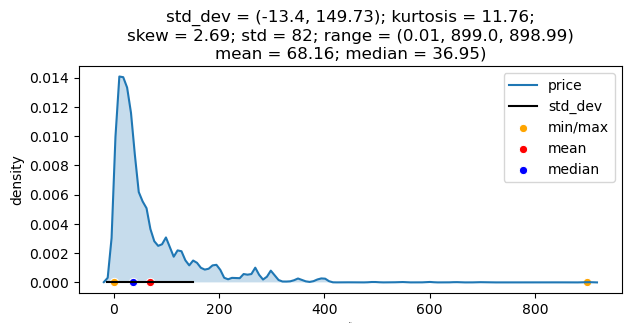

In [57]:
# Price: 
UVA_numeric(hp, ['price']);

* Average price of the product purchased is 68.16USD, Its biased towards the lower price. The prices range between 0.01USD to 899USD. median is lesser than the mean indicating left skewness, high kurtosis indicate that the distribution has thin tails. 

16.79 - 89.89


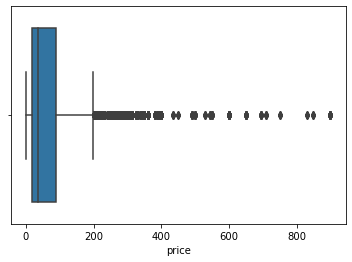

In [58]:
print(hp.price.quantile(0.25),'-',hp.price.quantile(0.75),)
sns.boxplot(hp.price);

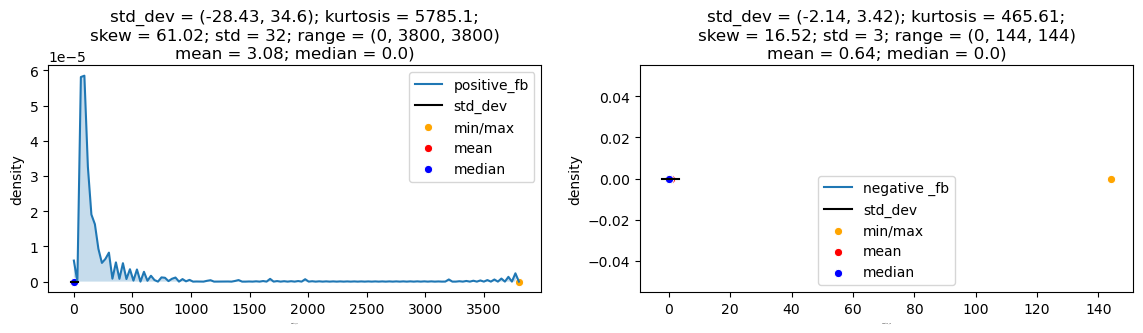

In [59]:
# Price: 
UVA_numeric(hp, ['positive_fb','negative _fb']);

In [60]:
hp.ratings.value_counts() 

5.0    31066
4.0    14639
3.0     7102
2.0     4452
1.0     3870
Name: ratings, dtype: int64

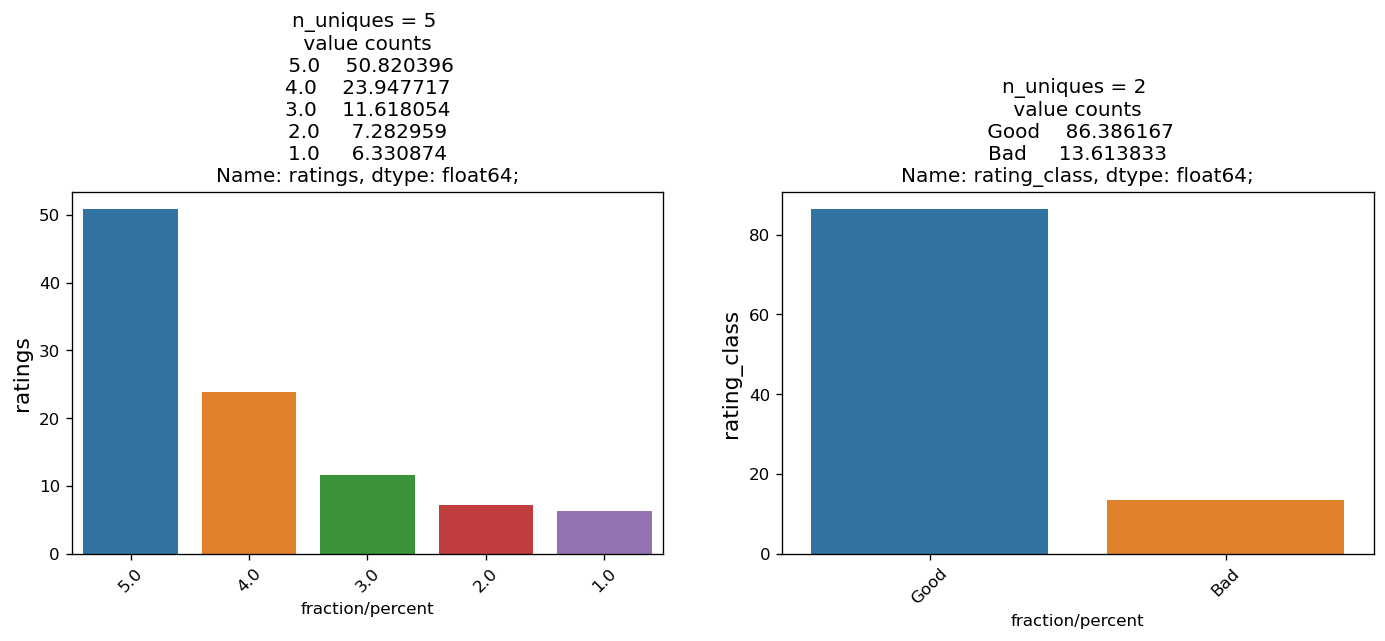

In [61]:
UVA_category(hp, ['ratings','rating_class'])

In [62]:
# Number of positive and negative feedbacks: 
print(len(hp[hp['positive_fb'] > 0 ]), '&', len(hp[hp['negative _fb'] > 0 ]))

25222 & 14202


## Preprocessing the text: 

The aim of this project is to classify the reviews into positive or negative sentiment. 

In [63]:
i = 1 
for word in hp['full_text'][0:5]: 
    print(str(i) +') ' + word)
    print()
    i += 1 

1) I've been using these for over a year now.  Basically, in a quiet environment these sound pretty good.  They aren't as good as similarly-priced studio-class headsets, but you're paying for the noise cancelling.  The raw capability is pretty decent, and has acceptable detail in treble, vocal, and bass ranges.The noise cancelling works pretty well.  I've taken these on several intercontinental flights and they do a decent job of blocking out engine rumble and screaming kids.  They also do a decent job of blocking out adult human voices, which is nice in the office.However, I must have pretty big ears, and I've found that the foam cups aren't quite thick enough to adequately push the driver away from my outer ear.  After 2 or 3 hours of use my ears start to ache a bit.The cord is plenty long, and can be disconnected in the middle to link to an optional Sony wired remote control.  An adapter to convert the standard 1/8th inch stereo jack to the dual 1/8th inch jacks in many airplane sea

In [64]:
# Create a function to clean the text in the column : 
def remove_special_characters(text, remove_digits=True):
    pattern = r'[^a-zA-z0-9\s]' if not remove_digits else r'[^a-zA-z\s]'
    text = re.sub(pattern, '', text)
    return text

hp['clean'] = hp.full_text.apply(remove_special_characters)

In [65]:
# Convert to lower case : 
hp['clean'] = hp.full_text.str.lower() 

In [66]:
# remove stopwords: 
stopwords_list= stopwords.words('english')
stopwords_list.append('ive')

def remove_stopwords(words): 
    new_words = [] 
    for word in words: 
        if word not in stopwords_list: 
            new_words.append(word)
    return new_words

# to stem words: 
def stem(words):
    stemmer = LancasterStemmer() 
    stems = [] 
    for word in words: 
        stem = stemmer.stem(word) 
        stems.append(stem)
    return stems

# to lemmatize the words: 
def lemmatizer_words_verbs(words): 
    lemmatizer = WordNetLemmatizer() 
    lemmas = [] 
    for word in words: 
        lem = lemmatizer.lemmatize(word, pos = 'v')
        lemmas.append(lem)
    return lemmas


def lemmatize(words): 
    lemmas = lemmatizer_words_verbs(words)
    return lemmas

def normalize_lemmatize(text): 
    sample = remove_special_characters(text) 
    words = nltk.word_tokenize(sample)
    words = remove_stopwords(words)
    lemmas = lemmatize(words)
    return ' '.join(lemmas)

In [67]:
hp['clean_trail'] = hp.clean.map(lambda text: normalize_lemmatize(text))

In [68]:
hp.head() 

,reviewerID,product_id,reviewer_name,ratings,unixReviewTime,url,description,categories,title,price,related,brand,full_text,positive_fb,negative _fb,rating_class,time,clean,clean_trail
1260,A3UFCX1AE4TKZE,B00000DMA3,Ben,4.0,1104796800,http://ecx.images-amazon.com/images/I/5156BXCV...,"Retreat to a world of music, sleep on airplane...","[[Electronics, Accessories & Supplies, Audio &...",Sony MDR-NC20 Noise Canceling Headphones with ...,109.94,"{'also_viewed': ['B000U07C1U', 'B001EYU3L2', '...",Sony,I've been using these for over a year now. Ba...,11,0,Good,2005-01-04,i've been using these for over a year now. ba...,use year basically quiet environment sound pre...
1261,A33FS5H3CPDR6D,B00000DMA3,"Miguel Ali ""Film Director & Political Pundit""",5.0,1106524800,http://ecx.images-amazon.com/images/I/5156BXCV...,"Retreat to a world of music, sleep on airplane...","[[Electronics, Accessories & Supplies, Audio &...",Sony MDR-NC20 Noise Canceling Headphones with ...,109.94,"{'also_viewed': ['B000U07C1U', 'B001EYU3L2', '...",Sony,I will admit that I recently gave up my Sony H...,12,1,Good,2005-01-24,i will admit that i recently gave up my sony h...,admit recently give sony headphones bang olufs...
1262,A1Q5M90ZZEEAL1,B00000DMA3,Niall O'Driscoll,3.0,1096934400,http://ecx.images-amazon.com/images/I/5156BXCV...,"Retreat to a world of music, sleep on airplane...","[[Electronics, Accessories & Supplies, Audio &...",Sony MDR-NC20 Noise Canceling Headphones with ...,109.94,"{'also_viewed': ['B000U07C1U', 'B001EYU3L2', '...",Sony,I bought these thinking they were the ticket t...,8,1,Good,2004-10-05,i bought these thinking they were the ticket t...,buy think ticket noisefree pleasant air travel...
1263,A1N03V52IRZ5PR,B00000DMA3,"N. J. Simicich ""Gadget Geek""",5.0,1093305600,http://ecx.images-amazon.com/images/I/5156BXCV...,"Retreat to a world of music, sleep on airplane...","[[Electronics, Accessories & Supplies, Audio &...",Sony MDR-NC20 Noise Canceling Headphones with ...,109.94,"{'also_viewed': ['B000U07C1U', 'B001EYU3L2', '...",Sony,I've owned these for years. I used to fly two ...,0,0,Good,2004-08-24,i've owned these for years. i used to fly two ...,own years use fly two round trip week wear con...
1264,A1W5G9ITZQ64TN,B00000DMA3,Stephen McLin,5.0,1117929600,http://ecx.images-amazon.com/images/I/5156BXCV...,"Retreat to a world of music, sleep on airplane...","[[Electronics, Accessories & Supplies, Audio &...",Sony MDR-NC20 Noise Canceling Headphones with ...,109.94,"{'also_viewed': ['B000U07C1U', 'B001EYU3L2', '...",Sony,I have used the headphones for 2 years -- they...,10,2,Good,2005-06-05,i have used the headphones for 2 years -- they...,use headphones years offer material reduction ...


In [69]:
i = 1 
for word in hp['clean_trail'][0:2]: 
    print(str(i) +') ' + word)
    print()
    i += 1 

1) use year basically quiet environment sound pretty good arent good similarlypriced studioclass headsets youre pay noise cancel raw capability pretty decent acceptable detail treble vocal bass rangesthe noise cancel work pretty well take several intercontinental flight decent job block engine rumble scream kid also decent job block adult human voice nice officehowever must pretty big ears find foam cup arent quite thick enough adequately push driver away outer ear hours use ears start ache bitthe cord plenty long disconnect middle link optional sony wire remote control adapter convert standard th inch stereo jack dual th inch jack many airplane seat includedthe thing dont like find uncomfortable try lean head window airplane sleep think mdrncs might better choice regardtheyre also kind bulky unless large carryon keep im paranoid put seat pocket front since mdrncs come soft bag instead rigid clamshell like bose headsets havent spill yet active travellers may wish find case thats rigida

In [70]:
hp.head() 

,reviewerID,product_id,reviewer_name,ratings,unixReviewTime,url,description,categories,title,price,related,brand,full_text,positive_fb,negative _fb,rating_class,time,clean,clean_trail
1260,A3UFCX1AE4TKZE,B00000DMA3,Ben,4.0,1104796800,http://ecx.images-amazon.com/images/I/5156BXCV...,"Retreat to a world of music, sleep on airplane...","[[Electronics, Accessories & Supplies, Audio &...",Sony MDR-NC20 Noise Canceling Headphones with ...,109.94,"{'also_viewed': ['B000U07C1U', 'B001EYU3L2', '...",Sony,I've been using these for over a year now. Ba...,11,0,Good,2005-01-04,i've been using these for over a year now. ba...,use year basically quiet environment sound pre...
1261,A33FS5H3CPDR6D,B00000DMA3,"Miguel Ali ""Film Director & Political Pundit""",5.0,1106524800,http://ecx.images-amazon.com/images/I/5156BXCV...,"Retreat to a world of music, sleep on airplane...","[[Electronics, Accessories & Supplies, Audio &...",Sony MDR-NC20 Noise Canceling Headphones with ...,109.94,"{'also_viewed': ['B000U07C1U', 'B001EYU3L2', '...",Sony,I will admit that I recently gave up my Sony H...,12,1,Good,2005-01-24,i will admit that i recently gave up my sony h...,admit recently give sony headphones bang olufs...
1262,A1Q5M90ZZEEAL1,B00000DMA3,Niall O'Driscoll,3.0,1096934400,http://ecx.images-amazon.com/images/I/5156BXCV...,"Retreat to a world of music, sleep on airplane...","[[Electronics, Accessories & Supplies, Audio &...",Sony MDR-NC20 Noise Canceling Headphones with ...,109.94,"{'also_viewed': ['B000U07C1U', 'B001EYU3L2', '...",Sony,I bought these thinking they were the ticket t...,8,1,Good,2004-10-05,i bought these thinking they were the ticket t...,buy think ticket noisefree pleasant air travel...
1263,A1N03V52IRZ5PR,B00000DMA3,"N. J. Simicich ""Gadget Geek""",5.0,1093305600,http://ecx.images-amazon.com/images/I/5156BXCV...,"Retreat to a world of music, sleep on airplane...","[[Electronics, Accessories & Supplies, Audio &...",Sony MDR-NC20 Noise Canceling Headphones with ...,109.94,"{'also_viewed': ['B000U07C1U', 'B001EYU3L2', '...",Sony,I've owned these for years. I used to fly two ...,0,0,Good,2004-08-24,i've owned these for years. i used to fly two ...,own years use fly two round trip week wear con...
1264,A1W5G9ITZQ64TN,B00000DMA3,Stephen McLin,5.0,1117929600,http://ecx.images-amazon.com/images/I/5156BXCV...,"Retreat to a world of music, sleep on airplane...","[[Electronics, Accessories & Supplies, Audio &...",Sony MDR-NC20 Noise Canceling Headphones with ...,109.94,"{'also_viewed': ['B000U07C1U', 'B001EYU3L2', '...",Sony,I have used the headphones for 2 years -- they...,10,2,Good,2005-06-05,i have used the headphones for 2 years -- they...,use headphones years offer material reduction ...


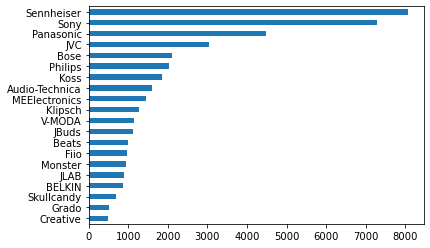

In [71]:
# Top brands: 
hp.brand.value_counts().head(20).sort_values().plot(kind = 'barh',);

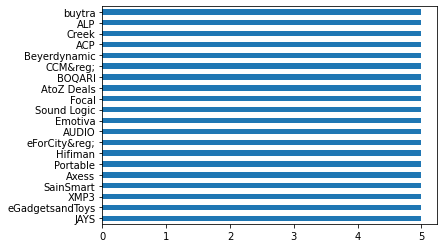

In [72]:
# Least reviewed brands: 
hp.brand.value_counts().tail(20).plot(kind = 'barh');

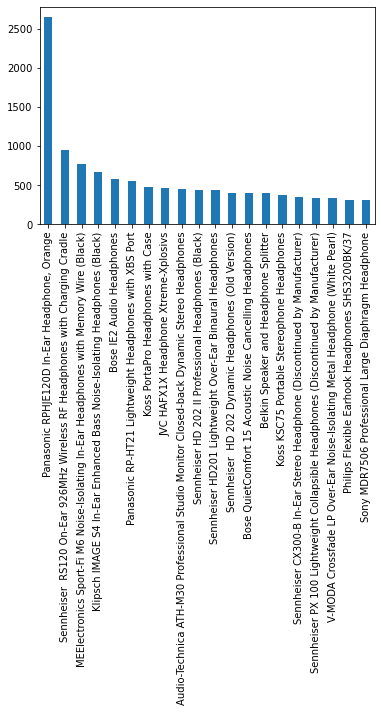

In [73]:
# Most purchased Product
hp.title.value_counts().head(20).plot(kind = 'bar',);

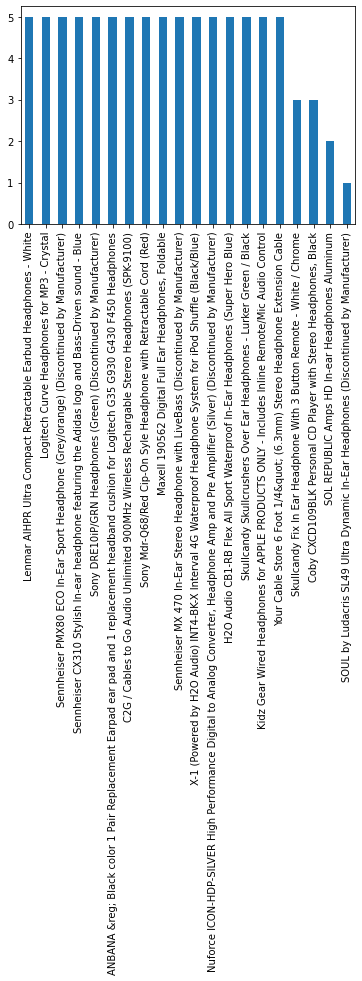

In [74]:
# least purchased Product
hp.title.value_counts().tail(20).plot(kind = 'bar',);

The most positively reviewed product in Amazon under headphones category is “Panasonic ErgoFit In-Ear Earbud Headphones RP-HJE120-D (Orange) Dynamic Crystal Clear Sound, Ergonomic Comfort-Fit”. This product had overall good rating more than 3.

In [75]:
hp['year'] = hp['time'].dt.year

In [76]:
pan= hp[hp['title'] == 'Panasonic RPHJE120D In-Ear Headphone, Orange']

In [77]:
pan 

,reviewerID,product_id,reviewer_name,ratings,unixReviewTime,url,description,categories,title,price,related,brand,full_text,positive_fb,negative _fb,rating_class,time,clean,clean_trail,year
760251,A3FWI03TTRIWDP,B003ELYQGG,1GoodDog,3.0,1399766400,http://ecx.images-amazon.com/images/I/41BqKcg6...,Panasonic In-Ear Headphone Comparison ChartSeries,"[[Electronics, Accessories & Supplies, Audio &...","Panasonic RPHJE120D In-Ear Headphone, Orange",7.04,"{'also_bought': ['B00JKC3M5O', 'B007CT7TAQ', '...",Panasonic,these are super cheap and mostly you get what ...,0,0,Good,2014-05-11,these are super cheap and mostly you get what ...,super cheap mostly get pay sound quality good ...,2014
760252,A1L5WUVR2RHCD6,B003ELYQGG,&#281;&#316;&#261;&#303;&#326;&#281;,5.0,1361577600,http://ecx.images-amazon.com/images/I/41BqKcg6...,Panasonic In-Ear Headphone Comparison ChartSeries,"[[Electronics, Accessories & Supplies, Audio &...","Panasonic RPHJE120D In-Ear Headphone, Orange",7.04,"{'also_bought': ['B00JKC3M5O', 'B007CT7TAQ', '...",Panasonic,I hate buying new earphones because they never...,0,0,Good,2013-02-23,i hate buying new earphones because they never...,hate buy new earphones never seem meet standar...,2013
760253,A2R0GTGI2NC5P7,B003ELYQGG,2DayShipping,5.0,1352246400,http://ecx.images-amazon.com/images/I/41BqKcg6...,Panasonic In-Ear Headphone Comparison ChartSeries,"[[Electronics, Accessories & Supplies, Audio &...","Panasonic RPHJE120D In-Ear Headphone, Orange",7.04,"{'also_bought': ['B00JKC3M5O', 'B007CT7TAQ', '...",Panasonic,So I bought these headphones because I read a ...,1,0,Good,2012-11-07,so i bought these headphones because i read a ...,buy headphones read review cnetcoms list low c...,2012
760254,AFT4I4KKUPEQP,B003ELYQGG,2pacleo,3.0,1370476800,http://ecx.images-amazon.com/images/I/41BqKcg6...,Panasonic In-Ear Headphone Comparison ChartSeries,"[[Electronics, Accessories & Supplies, Audio &...","Panasonic RPHJE120D In-Ear Headphone, Orange",7.04,"{'also_bought': ['B00JKC3M5O', 'B007CT7TAQ', '...",Panasonic,"Good product, but for the price and better bad...",1,1,Good,2013-06-06,"good product, but for the price and better bad...",good product price better bad well isolation i...,2013
760255,AILMTQNLB90RV,B003ELYQGG,4lan,5.0,1358553600,http://ecx.images-amazon.com/images/I/41BqKcg6...,Panasonic In-Ear Headphone Comparison ChartSeries,"[[Electronics, Accessories & Supplies, Audio &...","Panasonic RPHJE120D In-Ear Headphone, Orange",7.04,"{'also_bought': ['B00JKC3M5O', 'B007CT7TAQ', '...",Panasonic,I used to hate cheap headphone/earbuds because...,0,0,Good,2013-01-19,i used to hate cheap headphone/earbuds because...,use hate cheap headphoneearbuds pain wear know...,2013
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
762898,A24WFOTXYB6EYJ,B003ELYQGG,"Z. Johnson ""musician_from_cal""",4.0,1365206400,http://ecx.images-amazon.com/images/I/41BqKcg6...,Panasonic In-Ear Headphone Comparison ChartSeries,"[[Electronics, Accessories & Supplies, Audio &...","Panasonic RPHJE120D In-Ear Headphone, Orange",7.04,"{'also_bought': ['B00JKC3M5O', 'B007CT7TAQ', '...",Panasonic,For around $6.00 these are a good deal. They ...,3,1,Good,2013-04-06,for around $6.00 these are a good deal. they ...,around good deal dont sound quite good sony md...,2013
762899,A2VL97OABZOWR4,B003ELYQGG,Zoie08,5.0,1402963200,http://ecx.images-amazon.com/images/I/41BqKcg6...,Panasonic In-Ear Headphone Comparison ChartSeries,"[[Electronics, Accessories & Supplies, Audio &...","Panasonic RPHJE120D In-Ear Headphone, Orange",7.04,"{'also_bought': ['B00JKC3M5O', 'B007CT7TAQ', '...",Panasonic,I bought a pair of these a few years ago. The...,0,0,Good,2014-06-17,i bought a pair of these a few years ago. the...,buy pair years ago start get old purchase anot...,2014
762900,A3K9AOX3G51QP4,B003ELYQGG,zombilex,5.0,1387756800,http://ecx.images-amazon.com/images/I/41BqKcg6...,Panasonic In-Ear Headphone Comparison ChartSeries,"[[Electronics, Accessories & Suppl

In [78]:
pan_plot = pd.DataFrame(pan.groupby(['year'])['ratings'].mean())

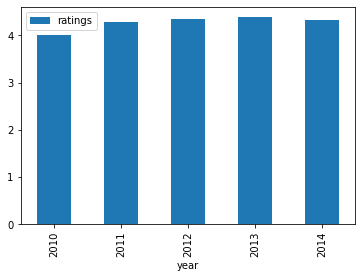

In [79]:
pan_plot.plot(kind = 'bar');

In [80]:
from nltk.tokenize import RegexpTokenizer
def RegExpTokenizer(Sent):
    tokenizer = RegexpTokenizer(r'\w+')
    return tokenizer.tokenize(Sent)

ListWords = []
for m in pan['clean_trail']:
    n = RegExpTokenizer(str(m))
    ListWords.append(n)
print(ListWords[10])

['headphones', 'work', 'wonderfully', 'little', 'concern', 'inexpensive', 'cancel', 'noise', 'quite', 'effectively', 'sound', 'quality', 'seem', 'good', 'ear', 'bud', 'headphones', 'previously', 'owened', 'great', 'sound', 'quality', 'affordable', 'price']


In [81]:
# All words: 
from nltk import FreqDist
def bag(ListWords): 
    all_words = [] 
    for word in ListWords: 
        for w in word: 
            all_words.append(w.lower())
    all_words1 = FreqDist(all_words)
    return all_words1

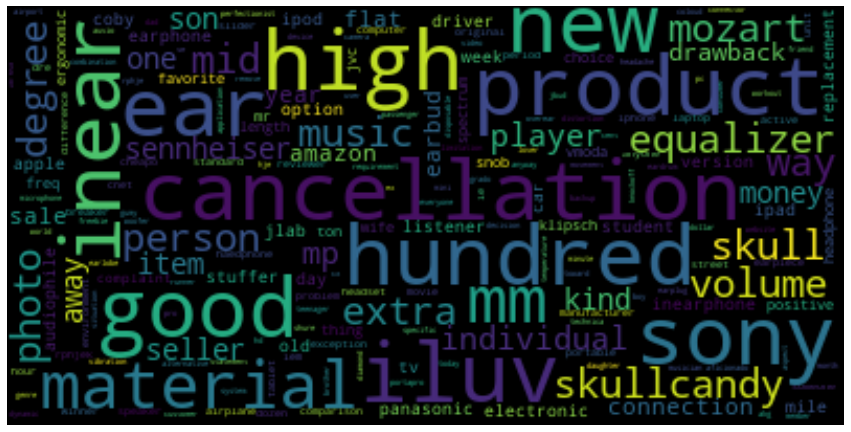

In [82]:
# Word Cloud 
from wordcloud import WordCloud

all_words_cloud = bag(ListWords)
ax = plt.figure(figsize=(15,10))
# Generate a word cloud image
wordcloud = WordCloud(background_color='black',max_font_size=40).generate(' '.join(all_words_cloud.keys()))

# Display the generated image:
# the matplotlib way:
import matplotlib.pyplot as plt
plt.imshow(wordcloud, interpolation='bilinear');
plt.axis("off");

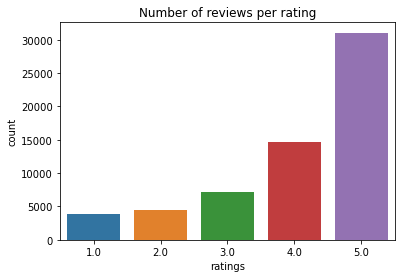

In [83]:
plt.title('Number of reviews per rating')
sns.countplot(hp.ratings);

In [84]:
hp.ratings.value_counts()

5.0    31066
4.0    14639
3.0     7102
2.0     4452
1.0     3870
Name: ratings, dtype: int64

In [85]:
hp.drop(['time'], axis = 1, inplace = True) 

In [86]:
hp.head(2)

,reviewerID,product_id,reviewer_name,ratings,unixReviewTime,url,description,categories,title,price,related,brand,full_text,positive_fb,negative _fb,rating_class,clean,clean_trail,year
1260,A3UFCX1AE4TKZE,B00000DMA3,Ben,4.0,1104796800,http://ecx.images-amazon.com/images/I/5156BXCV...,"Retreat to a world of music, sleep on airplane...","[[Electronics, Accessories & Supplies, Audio &...",Sony MDR-NC20 Noise Canceling Headphones with ...,109.94,"{'also_viewed': ['B000U07C1U', 'B001EYU3L2', '...",Sony,I've been using these for over a year now. Ba...,11,0,Good,i've been using these for over a year now. ba...,use year basically quiet environment sound pre...,2005
1261,A33FS5H3CPDR6D,B00000DMA3,"Miguel Ali ""Film Director & Political Pundit""",5.0,1106524800,http://ecx.images-amazon.com/images/I/5156BXCV...,"Retreat to a world of music, sleep on airplane...","[[Electronics, Accessories & Supplies, Audio &...",Sony MDR-NC20 Noise Canceling Headphones with ...,109.94,"{'also_viewed': ['B000U07C1U', 'B001EYU3L2', '...",Sony,I will admit that I recently gave up my Sony H...,12,1,Good,i will admit that i recently gave up my sony h...,admit recently give sony headphones bang olufs...,2005


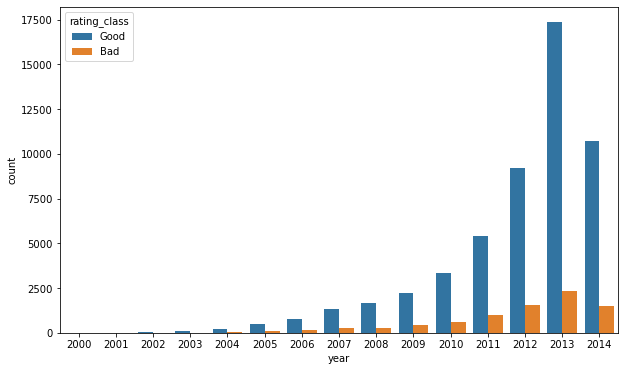

In [87]:
# NUMBER OF REVIEWS PER YEAR : 
plt.figure(figsize = (10,6))
sns.countplot(hp.year, hue = hp.rating_class);

(array([5.7834e+04, 2.6800e+03, 4.1100e+02, 1.0300e+02, 4.0000e+01,
        3.7000e+01, 1.4000e+01, 6.0000e+00, 2.0000e+00, 2.0000e+00]),
 array([    0. ,  1448.4,  2896.8,  4345.2,  5793.6,  7242. ,  8690.4,
        10138.8, 11587.2, 13035.6, 14484. ]),
 <a list of 10 Patch objects>)

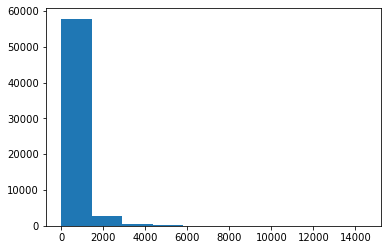

In [88]:
# DISTRIBUTION OF REVIEW LENGTH: 
plt.hist(hp.clean_trail.map(lambda x: len(x)))

In [89]:
review_length = hp.clean_trail.dropna().map(lambda x : len(x))

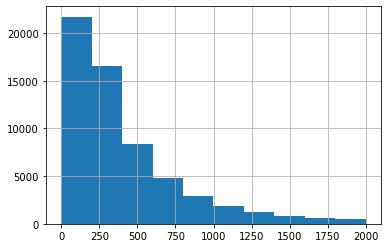

In [90]:
review_length.loc[review_length < 2000].hist() ;

In [91]:
review_length.shape

(61129,)

In [92]:
hp.year.dtype

dtype('int64')

In [93]:
# KEEPING REVIEWS FROM 2010 ONLY: 
latest = hp.drop(hp[(hp.year < 2010)].index)
latest.shape

(53019, 19)

In [94]:
latest['rating_num'] = latest.rating_class.map({'Good':1,'Bad':0})

In [95]:
def token(text): 
    token = [word for word in nltk.word_tokenize(text)]
    return token
latest['token'] = latest.clean_trail.apply(token)

In [96]:
latest.head()

,reviewerID,product_id,reviewer_name,ratings,unixReviewTime,url,description,categories,title,price,...,brand,full_text,positive_fb,negative _fb,rating_class,clean,clean_trail,year,rating_num,token
2332,A1WYKNREHQ30KE,B00000JBHP,"A. Jones ""anjsmiles""",4.0,1294617600,http://ecx.images-amazon.com/images/I/41PssPkA...,,"[[Electronics, Accessories & Supplies, Audio &...",Yamaha RH1C Portable Headphones,9.86,...,Yamaha,Nice headphones. No noise escapes the headphon...,0,0,Good,nice headphones. no noise escapes the headphon...,nice headphones noise escape headphones distur...,2011,1,"[nice, headphones, noise, escape, headphones, ..."
2333,A24PTVSZSM8968,B00000JBHP,Amazon Customer,4.0,1362182400,http://ecx.images-amazon.com/images/I/41PssPkA...,,"[[Electronics, Accessories & Supplies, Audio &...",Yamaha RH1C Portable Headphones,9.86,...,Yamaha,These headphones have some nice features. They...,0,1,Good,these headphones have some nice features. they...,headphones nice feature nice shape fit comfort...,2013,1,"[headphones, nice, feature, nice, shape, fit, ..."
2334,A4DZOJ79D9BXE,B00000JBHP,Angelina Lotulelei,4.0,1371513600,http://ecx.images-amazon.com/images/I/41PssPkA...,,"[[Electronics, Accessories & Supplies, Audio &...",Yamaha RH1C Portable Headphones,9.86,...,Yamaha,They are not exactly noise cancelling as I rea...,0,0,Good,they are not exactly noise cancelling as i rea...,exactly noise cancel read review hear tv littl...,2013,1,"[exactly, noise, cancel, read, review, hear, t..."
2335,A104VHQ06KFLDT,B00000JBHP,Anthony Whiteman,4.0,1278720000,http://ecx.images-amazon.com/images/I/41PssPkA...,,"[[Electronics, Accessories & Supplies, Audio &...",Yamaha RH1C Portable Headphones,9.86,...,Yamaha,"This headset is inexpensive, so don't expect a...",7,0,Good,"this headset is inexpensive, so don't expect a...",headset inexpensive dont expect product years ...,2010,1,"[headset, inexpensive, dont, expect, product, ..."
2336,AGI34T5QZWBBC,B00000JBHP,"Dee L. ""Dee""",5.0,1400284800,http://ecx.images-amazon.com/images/I/41PssPkA...,,"[[Electronics, Accessories & Supplies, Audio &...",Yamaha RH1C Portable Headphones,9.86,...,Yamaha,I purchased these headphones to go w/my electr...,0,0,Good,i purchased these headphones to go w/my electr...,purchase headphones go wmy electric piano deli...,2014,1,"[purchase, headphones, go, wmy, electric, pian..."


In [97]:
# def token(text): 
#     token = [ word for word in nltk.word_tokenize(text)]
#     return token 
def length(text): 
    length = len([w for w in nltk.word_tokenize(text)])
    return length
latest['review_length'] = latest.clean_trail.apply(length)

In [98]:
latest.head() 

,reviewerID,product_id,reviewer_name,ratings,unixReviewTime,url,description,categories,title,price,...,full_text,positive_fb,negative _fb,rating_class,clean,clean_trail,year,rating_num,token,review_length
2332,A1WYKNREHQ30KE,B00000JBHP,"A. Jones ""anjsmiles""",4.0,1294617600,http://ecx.images-amazon.com/images/I/41PssPkA...,,"[[Electronics, Accessories & Supplies, Audio &...",Yamaha RH1C Portable Headphones,9.86,...,Nice headphones. No noise escapes the headphon...,0,0,Good,nice headphones. no noise escapes the headphon...,nice headphones noise escape headphones distur...,2011,1,"[nice, headphones, noise, escape, headphones, ...",26
2333,A24PTVSZSM8968,B00000JBHP,Amazon Customer,4.0,1362182400,http://ecx.images-amazon.com/images/I/41PssPkA...,,"[[Electronics, Accessories & Supplies, Audio &...",Yamaha RH1C Portable Headphones,9.86,...,These headphones have some nice features. They...,0,1,Good,these headphones have some nice features. they...,headphones nice feature nice shape fit comfort...,2013,1,"[headphones, nice, feature, nice, shape, fit, ...",42
2334,A4DZOJ79D9BXE,B00000JBHP,Angelina Lotulelei,4.0,1371513600,http://ecx.images-amazon.com/images/I/41PssPkA...,,"[[Electronics, Accessories & Supplies, Audio &...",Yamaha RH1C Portable Headphones,9.86,...,They are not exactly noise cancelling as I rea...,0,0,Good,they are not exactly noise cancelling as i rea...,exactly noise cancel read review hear tv littl...,2013,1,"[exactly, noise, cancel, read, review, hear, t...",37
2335,A104VHQ06KFLDT,B00000JBHP,Anthony Whiteman,4.0,1278720000,http://ecx.images-amazon.com/images/I/41PssPkA...,,"[[Electronics, Accessories & Supplies, Audio &...",Yamaha RH1C Portable Headphones,9.86,...,"This headset is inexpensive, so don't expect a...",7,0,Good,"this headset is inexpensive, so don't expect a...",headset inexpensive dont expect product years ...,2010,1,"[headset, inexpensive, dont, expect, product, ...",22
2336,AGI34T5QZWBBC,B00000JBHP,"Dee L. ""Dee""",5.0,1400284800,http://ecx.images-amazon.com/images/I/41PssPkA...,,"[[Electronics, Accessories & Supplies, Audio &...",Yamaha RH1C Portable Headphones,9.86,...,I purchased these headphones to go w/my electr...,0,0,Good,i purchased these headphones to go w/my electr...,purchase headphones go wmy electric piano deli...,2014,1,"[purchase, headphones, go, wmy, electric, pian...",23


In [208]:
condition = (latest['review_length'] > 150) & (latest['rating_num'] == '1')

In [209]:
df = latest.drop(latest[condition].index)

In [210]:
condition2 = (df.year == 2010)
df = df.drop(df[condition2].index)

In [211]:
df.year.dtype

dtype('int64')

In [212]:
df.shape

(49074, 22)

In [250]:
df = df.head(1000)

In [251]:
df = df[['clean_trail','rating_num']].reset_index() 
df.head(10)

,index,clean_trail,rating_num
0,0,nice headphones noise escape headphones distur...,1
1,1,headphones nice feature nice shape fit comfort...,1
2,2,exactly noise cancel read review hear tv littl...,1
3,3,purchase headphones go wmy electric piano deli...,1
4,4,choose item go synthesizer fit perfect hear cl...,1
5,5,sound good headphones use watch movies tube pr...,1
6,6,get student practice whiteout hasslesdecent ma...,1
7,7,buy son practice piano doesnt like current hea...,1
8,8,terrific make adjustment individual eq vocals ...,1
9,9,inexpensive earphones provide adequate render ...,0


In [252]:
df.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   index        1000 non-null   int64 
 1   clean_trail  1000 non-null   object
 2   rating_num   1000 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 23.6+ KB


In [253]:
sample = df.copy()

In [254]:
# sample = sample.sample(5000, replace = False)

In [255]:
# Initialize count vector 
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer(ngram_range = (1,2), binary = True)

In [256]:
cv.fit(sample.clean_trail)

CountVectorizer(binary=True, ngram_range=(1, 2))

In [257]:
# transform the matrix : 
matrix = cv.transform(sample.clean_trail)

In [258]:
mat = matrix.toarray() 

In [259]:
names = cv.get_feature_names()

In [260]:
# Adding a rating col from previous df 
data = pd.DataFrame(mat, columns = names)

In [262]:
data['rating'] = df['rating_num']

In [263]:
data

,aa,aa open,aa qz,aahead,aahead rest,abba,abba neil,abed,abed bass,abilities,...,zone switch,zune,zune put,zunes,zunes players,zx,zx headphones,zxboth,zxboth bose,rating
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
996,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
997,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
998,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
